In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd

import os
import sys
assert sys.version_info >= (3, 5)

from pathlib import Path
from pprint import pprint
import glob
import shutil
import itertools
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

import cv2
import openslide

# Seed
np.random.seed(42)

dirpath = Path.cwd()
print(dirpath)
sys.path.append(str(dirpath/'../src'))

# from deephistopath.wsi import filter
from deephistopath.wsi import slide
# from deephistopath.wsi import tiles
from deephistopath.wsi import util

from build_tfrec import (calc_records_in_tfr_folder, calc_examples_in_tfrecord,
                         show_img, show_images, encode_categorical,
                         _float_feature, _bytes_feature, _int64_feature,
                         np_img_to_bytes
                        )

Num GPUs Available:  0
/vol/ml/apartin/projects/pdx-histo/nbs
Num GPUs Available:  0


# Load data

In [4]:
# Path
datapath = Path('../data')
tiles_path = datapath/'tiles_png'
tfr_path = datapath/'tfrecords'
os.makedirs(tfr_path, exist_ok=True)

# Read dataframe
data = pd.read_csv(datapath/'data_merged.csv')
print('data', data.shape)
display(data.iloc[:2, :8])
csite_enc = encode_categorical(df=data, label_name='csite', label_value='csite_label')
ctype_enc = encode_categorical(df=data, label_name='ctype', label_value='ctype_label')
CSITE_NUM_CLASSES = len(csite_enc.keys())
CTYPE_NUM_CLASSES = len(ctype_enc.keys())

GE_LEN = sum([1 for c in data.columns if c.startswith('ge_')])
DD_LEN = sum([1 for c in data.columns if c.startswith('dd_')])

Num GPUs Available:  0
data (2004, 2607)


,Sample,model,patient_id,sample_id,Drug1,Response,ID,NAME
0,435261~313-R~H25M89,435261,313-R,H25M89,NSC.616348,0,NSC.616348,irinotecan
1,172845~288-R~J38JF0,172845,288-R,J38JF0,NSC.616348,0,NSC.616348,irinotecan


In [5]:
# Create column of unique treatments
col_name = 'smp'
if col_name not in data.columns:
    jj = [str(s) + '_' + str(d) for s, d in zip(data.Sample, data.Drug1)]
    data.insert(loc=0, column=col_name, value=jj, allow_duplicates=False)

# Subsample data

In [6]:
# -----------------------------------------------------------------------------
# Subsample data to create balanced dataset in terms of drug response and ctype
# -----------------------------------------------------------------------------
r0 = data[data.Response == 0]  # non-responders
r1 = data[data.Response == 1]  # responders

dfs = []
for ctype, count in r1.ctype.value_counts().items():
    # print(ctype, count)
    aa = r0[r0.ctype == ctype]
    if aa.shape[0] > count:
        aa = aa.sample(n=count)
    dfs.append(aa)

aa = pd.concat(dfs, axis=0)
df = pd.concat([aa, r1], axis=0).reset_index(drop=True)
print(df.shape)

aa = df.reset_index()
display(aa.groupby(['ctype', 'Response']).agg({'index': 'nunique'}).reset_index())

data = df
del dfs, df, aa, ctype, count

(74, 2608)


,ctype,Response,index
0,digestive/gastrointestinal,0,16
1,digestive/gastrointestinal,1,16
2,lung,0,12
3,lung,1,12
4,skin other,0,4
5,skin other,1,4
6,squamous,0,5
7,squamous,1,5


## Copy slides to training_slides

In [8]:
src_img_path = datapath/'doe-globus-pdx-data'
dst_img_path = datapath/'training_slides'
os.makedirs(dst_img_path, exist_ok=True)

# Copy slides to training_slides folder
exist = []
copied = []
for fname in data.image_id.unique():
    if (dst_img_path/f'{fname}.svs').exists():
        # print(f'\t{fname} already exists.')
        exist.append(fname)
    else:
        _ = shutil.copyfile(str(src_img_path/f'{fname}.svs'), str(dst_img_path/f'{fname}.svs'))
        copied.append(fname)

print(f'Copied slides:   {len(copied)}')
print(f'Existing slides: {len(exist)}')

Copied slides:   0
Existing slides: 50


# Build TFRecords

In [13]:
data.T.iloc[:20, :2]

,0,1
smp,165739~295-R~AM1_NSC.616348,186413~043-R~UQ7VT8W69_NSC.241240
Sample,165739~295-R~AM1,186413~043-R~UQ7VT8W69
model,165739,186413
patient_id,295-R,043-R
sample_id,AM1,UQ7VT8W69
Drug1,NSC.616348,NSC.241240
Response,0,0
ID,NSC.616348,NSC.241240
NAME,irinotecan,Carboplatin
CLEAN_NAME,IRINOTECAN,CARBOPLATIN


(303, 303, 3)
(303, 303)


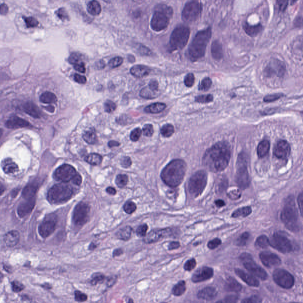

In [10]:
# Load tile into np
i, item = next(data.iterrows())
tiles_path_list = list(tiles_path.glob(f'{item.image_id}-tile*.png'))
np_img = slide.open_image_np(str(tiles_path_list[0]), verbose=False);
img = slide.open_image(str(tiles_path_list[0]));
print(np_img.shape)
print(img.size)

# show_img(np_img)
display(img)

In [14]:
# ----------------
# Create tfrecords
# ----------------
n_samples = 1
# n_samples = data.shape[0]

# Iter over treatment samples
for i, item in itertools.islice(data.iterrows(), n_samples):
# for i, item in data.iterrows():
    # Prefix rna and drug features
    ge_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('ge_')]
    dd_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('dd_')]
    
    tfr_fname = tfr_path/f'train_{item.smp}.tfrecord'  # tfrecord filename
    tiles_path_list = list(tiles_path.glob(f'{item.image_id}-tile*.png'))  # load slide tiles
    writer = tf.io.TFRecordWriter(str(tfr_fname))  # create tfr writer
    
    # Iter over tiles
    for tile_path in tiles_path_list:
        np_img = slide.open_image_np(str(tile_path), verbose=False)
        img_bytes = np_img_to_bytes(np_img)
        
        # Prep features for current example to be assigned into the tfrecord
        feature = {
                'ge_vec': _float_feature(ge_vec),
                'dd_vec': _float_feature(dd_vec),

                'smp': _bytes_feature(bytes(item['smp'], 'utf-8')),
                'rsp': _int64_feature(item['Response']),
                'image_id': _int64_feature(item['image_id']),
                
                # tile
                'image_raw': _bytes_feature(img_bytes),
                # TODO tile meta                

                'Sample': _bytes_feature(bytes(item['Sample'], 'utf-8')),
                'ctype': _bytes_feature(bytes(item['ctype'], 'utf-8')),
                'csite': _bytes_feature(bytes(item['csite'], 'utf-8')),
                'ctype_label': _int64_feature(item['ctype_label']),
                'csite_label': _int64_feature(item['csite_label']),
        }
        ex = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(ex.SerializeToString())
    
    writer.close()
    print('\nFinished building tfrecords.')


Finished building tfrecords.


In [15]:
tfr_files = sorted(tfr_path.glob('*.tfrec*'))
print('Number of tfrecords the folder:', len(tfr_files))
calc_records_in_tfr_folder(tfr_dir=tfr_path)
calc_examples_in_tfrecord(tfr_path=str(tfr_files[0]))

Number of tfrecords the folder: 1
Number of examples in all tfrecords in the folder: 40
Number of examples in the tfrecord: 40


In [12]:
# -----------------------------------------------
# Read single tfrecord and explore single example
# -----------------------------------------------
GE_LEN = len(ge_vec)
DD_LEN = len(dd_vec)

# Feature specs (used to read an example from tfrecord)
fea_spec = {
    'ge_vec': tf.io.FixedLenFeature(shape=(GE_LEN,), dtype=tf.float32, default_value=None),
    'dd_vec': tf.io.FixedLenFeature(shape=(DD_LEN,), dtype=tf.float32, default_value=None),    
    
    'smp':      tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 
    'rsp': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 
    'image_id': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 
    
    'image_raw': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    
    'Sample': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'ctype':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'csite':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),    
    'ctype_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
    'csite_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
}

# Create tf dataset object
fname = 'train_165739~295-R~AM1_NSC.616348.tfrecord'
ds = tf.data.TFRecordDataset(str(tfr_path/fname))

# Get single tfr example
ex = next(ds.__iter__())
ex = tf.io.parse_single_example(ex, features=fea_spec)  # returns the features for a given example in a dict, ex_fea_dct
print('Feature types in the tfrecord example:\n{}'.format(ex.keys()))

# Bytes
print('\nBytes (csite):')
print(ex['csite'].numpy())
print(ex['csite'].numpy().decode('UTF-8'))

# Float
print('\nFloat (csite_label):')
print(ex['csite_label'])
print(ex['csite_label'].numpy())

# Int
print('\nInt (rsp):')
print(ex['rsp'])
print(ex['rsp'].numpy())

# Float
print('\nFloat (ge_vec):')
print(ex['ge_vec'][:10])
print(ex['ge_vec'].numpy()[:10])

# Bytes
print('\nBytes (image_raw):')
img = tf.image.decode_jpeg(ex['image_raw'], channels=3)
print(img.numpy().shape)
# show_img(img)

Feature types in the tfrecord example:
dict_keys(['Sample', 'csite', 'csite_label', 'ctype', 'ctype_label', 'dd_vec', 'ge_vec', 'image_id', 'image_raw', 'rsp', 'smp'])

Bytes (csite):
b'digestive/gastrointestinal'
digestive/gastrointestinal

Float (csite_label):
tf.Tensor(1, shape=(), dtype=int64)
1

Int (rsp):
tf.Tensor(0, shape=(), dtype=int64)
0

Float (ge_vec):
tf.Tensor(
[11.821672   7.058837   7.9992366 10.545321   9.342794   8.882652
  4.42414    9.0802145  8.827607   8.250843 ], shape=(10,), dtype=float32)
[11.821672   7.058837   7.9992366 10.545321   9.342794   8.882652
  4.42414    9.0802145  8.827607   8.250843 ]

Bytes (image_raw):
(303, 303, 3)


# Build tf dataset for training with TF2

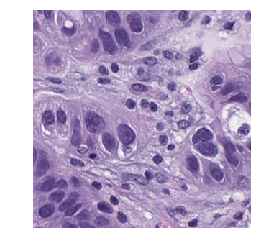

(303, 303, 3)


In [13]:
# Get single img
img = ex['image_raw']
img = tf.image.decode_jpeg(img, channels=3)
img = tf.cast(img, tf.float32) / 255.0
dim = img.shape[0]
img = tf.image.random_flip_left_right(img)
img = tf.image.random_flip_up_down(img)
img = tf.reshape(img, [dim, dim, 3])
show_img(img)
print(img.shape)
# img

In [47]:
# def prepare_image(img, augment=True, dim=256):
def prepare_image(img, augment=True):  
    """ Deotte. """
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        # https://www.tensorflow.org/api_docs/python/tf/image/random_flip_up_down
        # img = transform(img, DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        # img = tf.image.random_saturation(img, 0.7, 1.3)
        # img = tf.image.random_contrast(img, 0.8, 1.2)
        # img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_flip_up_down(img)  # ap

    # img = tf.reshape(img, [dim, dim, 3])  
    return img

# Note! because this func returns inputs and outputs, it's probably needs to change depending on the prediction task 
def read_tfr_example(ex, augment=True):
    """ Read and parse a single example from a tfrecord. """
    ex = tf.io.parse_single_example(ex, fea_spec)
    
    # Image data
    img = ex['image_raw']
    img = prepare_image(img, augment=augment)  # Deotte
    
    # RNA and descriptors
    ge_vec = tf.cast(ex['ge_vec'], tf.float32)
    dd_vec = tf.cast(ex['dd_vec'], tf.float32)
    
    # Inputs
    inputs = {'ge_vec': ge_vec, 'dd_vec': dd_vec, 'img': img}
    
    # --------------------
    # Multitask classifier
    # --------------------    
#     # Outputs
#     csite_label = tf.cast(ex['csite_label'], tf.int64)
#     ctype_label = tf.cast(ex['ctype_label'], tf.int64)
    
#     # One-hot
#     csite_label = tf.one_hot(indices=csite_label, depth=CSITE_NUM_CLASSES, on_value=1.0, off_value=0.0)
#     ctype_label = tf.one_hot(indices=ctype_label, depth=CTYPE_NUM_CLASSES, on_value=1.0, off_value=0.0)
    
#     csite_label = tf.reshape(csite_label, [CSITE_NUM_CLASSES,])
#     ctype_label = tf.reshape(ctype_label, [CTYPE_NUM_CLASSES,])    
    
#     # Put into dict
# #     outputs = {'csite_label': csite_label}
#     outputs = {'csite_label': csite_label, 'ctype_label': ctype_label}

    # --------------------
    # Classifier
    # --------------------
    rsp = tf.cast(ex['rsp'], tf.int64)
    outputs = {'rsp': rsp}
    
    return inputs, outputs

In [58]:
# Train and val filenames
train_filenames = glob(os.path.join(tfr_path, 'train*.tfrecord'))
val_filenames   = glob(os.path.join(tfr_path, 'val*.tfrecord'))

ds = tf.data.TFRecordDataset(filenames=train_filenames)
# ds = ds.map(read_tfr_example)
ds = ds.map(lambda ex: read_tfr_example(ex, augment=True))

# Take an example
ex = next(ds.take(1).__iter__())
print('Inputs: ', ex[0].keys())
print('Outputs:', ex[1].keys())

# print(ex[0]['ge_vec'].numpy().shape)
for i, fea_name in enumerate(ex[0].keys()):
    print(fea_name, ex[0][fea_name].numpy().shape)
    
# # print(ex[1]['csite_label'].numpy())
# # print(ex[1]['ctype_label'].numpy())
for i, out_name in enumerate(ex[1].keys()):
    print(out_name, ex[1][out_name].numpy().shape)

Inputs:  dict_keys(['ge_vec', 'dd_vec', 'img'])
Outputs: dict_keys(['rsp'])
ge_vec (976,)
dd_vec (1613,)
img (303, 303, 3)
rsp ()


In [5]:
# Divide the df into smaller dfs
n_tfrecords = 5
d = int(data.shape[0]/n_tfrecords)
dfs = []

for i in range(n_tfrecords):
    i0 = i * d
    i1 = (i + 1) * d
    if i == n_tfrecords - 1:
        i1 = None
    dfs.append(data.iloc[i0:i1])
    
[df.shape for df in dfs]

[(403, 2607), (403, 2607), (403, 2607), (403, 2607), (405, 2607)]

In [6]:
# next(dfs[1].iterrows())[1]
# next(dfs[1].iterrows())[1].index
# next(dfs[1].iterrows())[1].values

# item = next(dfs[1].iterrows())[1]
# ge_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('ge_')]
# dd_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('dd_')]
# item['Sample']

In [9]:
# Create tfrecords
# ----------------
# Ourdir
tfr_out = Path.cwd()/'tfr_from_csv'
os.makedirs(tfr_out, exist_ok=True)

# Randomize the dfs
randomize = False
if randomize:
    import random
    random.shuffle(dfs)
    
n_tr_dfs = 4  # num of train tfr files
n_vl_dfs = 1  # num of val tfr files
tr_sz = 0     # counter for training examples
vl_sz = 0     # counter for val examples

for i, df in enumerate(dfs):
    i += 1

    if i <= n_tr_dfs:
        tfr_fname = tfr_out/f'train_{i}.tfrecord'
        tr_sz += df.shape[0]
    else:
        tfr_fname = tfr_out/f'val_{i}.tfrecord'
        vl_sz += df.shape[0]
        
    # Create tfr writer
    writer = tf.io.TFRecordWriter(str(tfr_fname))

    for i, item in df.iterrows():
        # Prefix rna and drug features
        ge_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('ge_')]
        dd_vec = [value for col_name, value in zip(item.index, item.values) if col_name.startswith('dd_')]
        
        ex = tf.train.Example(features=tf.train.Features(
            feature={
                'ge_vec': tf.train.Feature(float_list=tf.train.FloatList(value=ge_vec)),
                'dd_vec': tf.train.Feature(float_list=tf.train.FloatList(value=dd_vec)),
                'Sample': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(item['Sample'], 'utf-8')])),
                'ctype_label': tf.train.Feature(int64_list=tf.train.Int64List(value=[item['ctype_label']])),
                'csite_label': tf.train.Feature(int64_list=tf.train.Int64List(value=[item['csite_label']])),
                'ctype': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(item['ctype'], 'utf-8')])),
                'csite': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(item['csite'], 'utf-8')]))
            }
        ))
 
        writer.write(ex.SerializeToString())

    writer.close()
    
print(f'Train samples {tr_sz}')
print(f'Val samples   {vl_sz}')

calc_examples_in_tfrecord(str(tfr_out/'val_5.tfrecord'))

Train samples 1612
Val samples   405
Number of examples in the tfrecord: 405


In [16]:
fea_spec = {
    'ge_vec': tf.io.FixedLenFeature(shape=(len(ge_vec),), dtype=tf.float32, default_value=None),
    'dd_vec': tf.io.FixedLenFeature(shape=(len(dd_vec),), dtype=tf.float32, default_value=None),    
    'Sample': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'ctype_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
    'csite_label':  tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
    'ctype':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'csite':  tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
}

ds = tf.data.TFRecordDataset(str(tfr_out/'train_1.tfrecord'))
ex = next(ds.__iter__())
ex = tf.io.parse_single_example(ex, features=fea_spec)
print(ex['csite'].numpy().decode('UTF-8'))
print(ex['csite_label'].numpy())
print(csite_enc)

digestive/gastrointestinal
1
{'bladder/urothelial': 0, 'digestive/gastrointestinal': 1, 'endocrine and neuroendocrine': 2, 'gynecologic': 3, 'head & neck': 4, 'kidney': 5, 'lung': 6, 'musculoskeletal': 7, 'skin': 8}


### Create tf datasets

In [16]:
# csite_classes = data['simplified_tumor_site'].values.tolist()
# ctype_classes = data['simplified_tumor_type'].values.tolist()
# tt = tf.convert_to_tensor(csite_classes)
tt = tf.convert_to_tensor(list(csite_enc.keys()))
tt = tf.data.Dataset.from_tensor_slices(tt)
for i in tt:
    # tf.print(i)
    print(i)

tf.Tensor(b'bladder/urothelial', shape=(), dtype=string)
tf.Tensor(b'digestive/gastrointestinal', shape=(), dtype=string)
tf.Tensor(b'endocrine and neuroendocrine', shape=(), dtype=string)
tf.Tensor(b'gynecologic', shape=(), dtype=string)
tf.Tensor(b'head & neck', shape=(), dtype=string)
tf.Tensor(b'kidney', shape=(), dtype=string)
tf.Tensor(b'lung', shape=(), dtype=string)
tf.Tensor(b'musculoskeletal', shape=(), dtype=string)
tf.Tensor(b'skin', shape=(), dtype=string)


In [18]:
# class Dataset():
    
#     def __init__(self, filenames):
#         self.filenames = filenames
    
#     def define_fea_spec(fea_spec):
#         self.fea_spec = fea_spec

fea_spec = {
    'ge_vec':      tf.io.FixedLenFeature(shape=(976,), dtype=tf.float32, default_value=None),
    'dd_vec':      tf.io.FixedLenFeature(shape=(1613,), dtype=tf.float32, default_value=None),    
    'Sample':      tf.io.FixedLenFeature(shape=[1], dtype=tf.string, default_value=None),
    'ctype_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None),
    'csite_label': tf.io.FixedLenFeature(shape=[1], dtype=tf.int64, default_value=None),
    'ctype':       tf.io.FixedLenFeature(shape=[1], dtype=tf.string, default_value=None),
    'csite':       tf.io.FixedLenFeature(shape=[1], dtype=tf.string, default_value=None),
}    

def read_tfr_example(ex):
    """ Read and parse a single example from a tfrecord. """
    ex = tf.io.parse_single_example(ex, fea_spec)
    
    # Inputs
    ge_vec = tf.cast(ex['ge_vec'], tf.float32)
    dd_vec = tf.cast(ex['dd_vec'], tf.float32)
    inputs = {'ge_vec': ge_vec}
    
    # Outputs
    csite_label = tf.cast(ex['csite_label'], tf.int64)
    ctype_label = tf.cast(ex['ctype_label'], tf.int64)
    
    # One-hot
    csite_label = tf.one_hot(indices=csite_label, depth=CSITE_NUM_CLASSES, on_value=1.0, off_value=0.0)
    ctype_label = tf.one_hot(indices=ctype_label, depth=CTYPE_NUM_CLASSES, on_value=1.0, off_value=0.0)
    
    csite_label = tf.reshape(csite_label, [CSITE_NUM_CLASSES,])
    ctype_label = tf.reshape(ctype_label, [CTYPE_NUM_CLASSES,])    
    
    # Put into dict
#     outputs = {'csite_label': csite_label}
    outputs = {'csite_label': csite_label, 'ctype_label': ctype_label}
    return inputs, outputs


# Train and val filenames
train_filenames = glob(os.path.join(tfr_out, 'train*.tfrecord'))
val_filenames   = glob(os.path.join(tfr_out, 'val*.tfrecord'))

ds = tf.data.TFRecordDataset(filenames=train_filenames)
ds = ds.map(read_tfr_example)

# Take an example
ii = next(ds.take(1).__iter__())
print('Inputs: ', ii[0].keys())
print('Outputs:', ii[1].keys())

# print(ii[0]['ge_vec'].numpy().shape)
for i, k in enumerate(ii[0].keys()):
    print(k, ii[0][k].numpy().shape)
    
# print(ii[1]['csite_label'].numpy())
# print(ii[1]['ctype_label'].numpy())
for i, k in enumerate(ii[1].keys()):
    print(k, ii[1][k].numpy().shape)

Inputs:  dict_keys(['ge_vec'])
Outputs: dict_keys(['csite_label', 'ctype_label'])
ge_vec (976,)
csite_label (9,)
ctype_label (11,)


In [18]:
# read this:  https://www.tensorflow.org/datasets/performances
def get_tfr_dataset(filenames):
    """ Create tf dataset. """
    ds = tf.data.TFRecordDataset(filenames=filenames)
    ds = ds.shuffle(500, reshuffle_each_iteration=True)
    ds = ds.map(read_tfr_example)
    # ds = ds.batch(32, drop_remainder=True)
    ds = ds.batch(32)
    return ds

ds_train = get_tfr_dataset(train_filenames)
ds_val   = get_tfr_dataset(val_filenames)

# Take a sample
ii = next(ds_train.take(1).__iter__())
# ii = next(ds_val.take(1).__iter__())
print('Inputs: ', ii[0].keys())
print('Outputs:', ii[1].keys())

# print(ii[0]['ge_vec'].numpy().shape)
# print(ii[1]['csite_label'].numpy().shape)
# print(ii[1]['ctype_label'].numpy().shape)

# print(ii[0]['ge_vec'].numpy().shape)
for i, k in enumerate(ii[0].keys()):
    print(k, ii[0][k].numpy().shape)
    
# print(ii[1]['csite_label'].numpy())
# print(ii[1]['ctype_label'].numpy())
for i, k in enumerate(ii[1].keys()):
    print(k, ii[1][k].numpy().shape)

Inputs:  dict_keys(['ge_vec'])
Outputs: dict_keys(['csite_label', 'ctype_label'])
ge_vec (32, 976)
csite_label (32, 9)
ctype_label (32, 11)


In [19]:
# def preprocess(ex):
#     ex = tf.io.parse_single_example(ex, features=fea_spec)
#     # sample = ex['Sample'][0].numpy().decode('utf-8')
#     sample = tf.cast(ex['Sample'], tf.string)
#     return sample

# # Train dataset
# ds = tf.data.TFRecordDataset(filenames=train_filenames)
# ds = ds.map(preprocess)
# ds = ds.shuffle(500, reshuffle_each_iteration=True)
# # ds = ds.batch(64)
# ii = next(ds.take(1).__iter__())
# print(ii[0].numpy().decode('utf-8'))

In [20]:
# Toy dataset
# -----------
# def power_two(x):
#     return x**2

# ds = tf.data.Dataset.range(10)
# ds = ds.map(power_two)
# ds = ds.repeat(1)
# ds = ds.shuffle(100, reshuffle_each_iteration=True)
# ds = ds.batch(2)
# for i, item in enumerate(ds):
#     tf.print(item, end=' ')

### Train Keras Type Classifier

In [21]:
import tensorflow as tf

# Inputs
input_ge = tf.keras.Input(shape=(len(ge_vec),), name='ge_vec')

# Hidden
fc = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(input_ge)
fc = tf.keras.layers.Dropout(0.2, name='dropout_1')(fc)
fc = tf.keras.layers.Dense(128, activation='relu', name='dense_2')(fc)
fc = tf.keras.layers.Dropout(0.2, name='dropout_2')(fc)

# Output
ctype_out = tf.keras.layers.Dense(CTYPE_NUM_CLASSES, activation='softmax', name='ctype_label')(fc)
csite_out = tf.keras.layers.Dense(CSITE_NUM_CLASSES, activation='softmax', name='csite_label')(fc)
# ctype_out = tf.keras.layers.Dense(1, activation='softmax', name='ctype_label')(fc)
# csite_out = tf.keras.layers.Dense(1, activation='softmax', name='csite_label')(fc)

# Model
model = tf.keras.Model(inputs=[input_ge], outputs=[ctype_out, csite_out])
# model = tf.keras.Model(inputs=[input_ge], outputs=[csite_out])
model.summary()

# ----------
# Compile
# ----------
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.categorical_crossentropy},
#               metrics=[tf.keras.metrics.categorical_crossentropy])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={'csite_label': tf.keras.losses.categorical_crossentropy,
                    'ctype_label': tf.keras.losses.categorical_crossentropy},
              metrics=[tf.keras.metrics.categorical_crossentropy])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.mean_absolute_error},
#               metrics=[tf.keras.metrics.mean_absolute_error])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss={'csite_label': tf.keras.losses.mean_absolute_error,
#                     'ctype_label': tf.keras.losses.mean_absolute_error},
#               metrics=[tf.keras.metrics.mean_absolute_error])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ge_vec (InputLayer)             [(None, 976)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          125056      ge_vec[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       dropout_1[0][0]                  
_______________________________________________________________________________________

In [22]:
# The choice of categorical_crossentropy vs sparse_categorical_crossentropy depends on the shape of labels depennds
# stackoverflow.com/questions/49161174/tensorflow-logits-and-labels-must-have-the-same-first-dimension
# ================================================================================================================
# history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

history = model.fit(ds_train,
                    epochs=20,
                    validation_data=ds_val,
                    verbose=False)

In [23]:
result = model.evaluate(ds_val, verbose=False)
dict(zip(model.metrics_names, result))

{'loss': 0.9979113936424255,
 'ctype_label_loss': 0.5338507890701294,
 'csite_label_loss': 0.4640606641769409,
 'ctype_label_categorical_crossentropy': 0.5338507890701294,
 'csite_label_categorical_crossentropy': 0.4640606641769409}

In [24]:
rr = model.predict(ds_val.repeat(1))
if isinstance(rr, list):
    print(rr[0].shape)
    print(rr[1].shape)
else:
    print(rr.shape)

(405, 11)
(405, 9)


In [78]:
for i, item in enumerate(ds_val):
    pass # print(item)
print(i)
print(ii[0]['ge_vec'].shape)
print(ii[1]['csite_label'].shape)
# print(ii[1]['ctype_label'].shape)

11
(32, 976)
(32, 1)


288